<a href="https://colab.research.google.com/github/dustoff06/EcoMod/blob/main/FERP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot of the FERP Contours

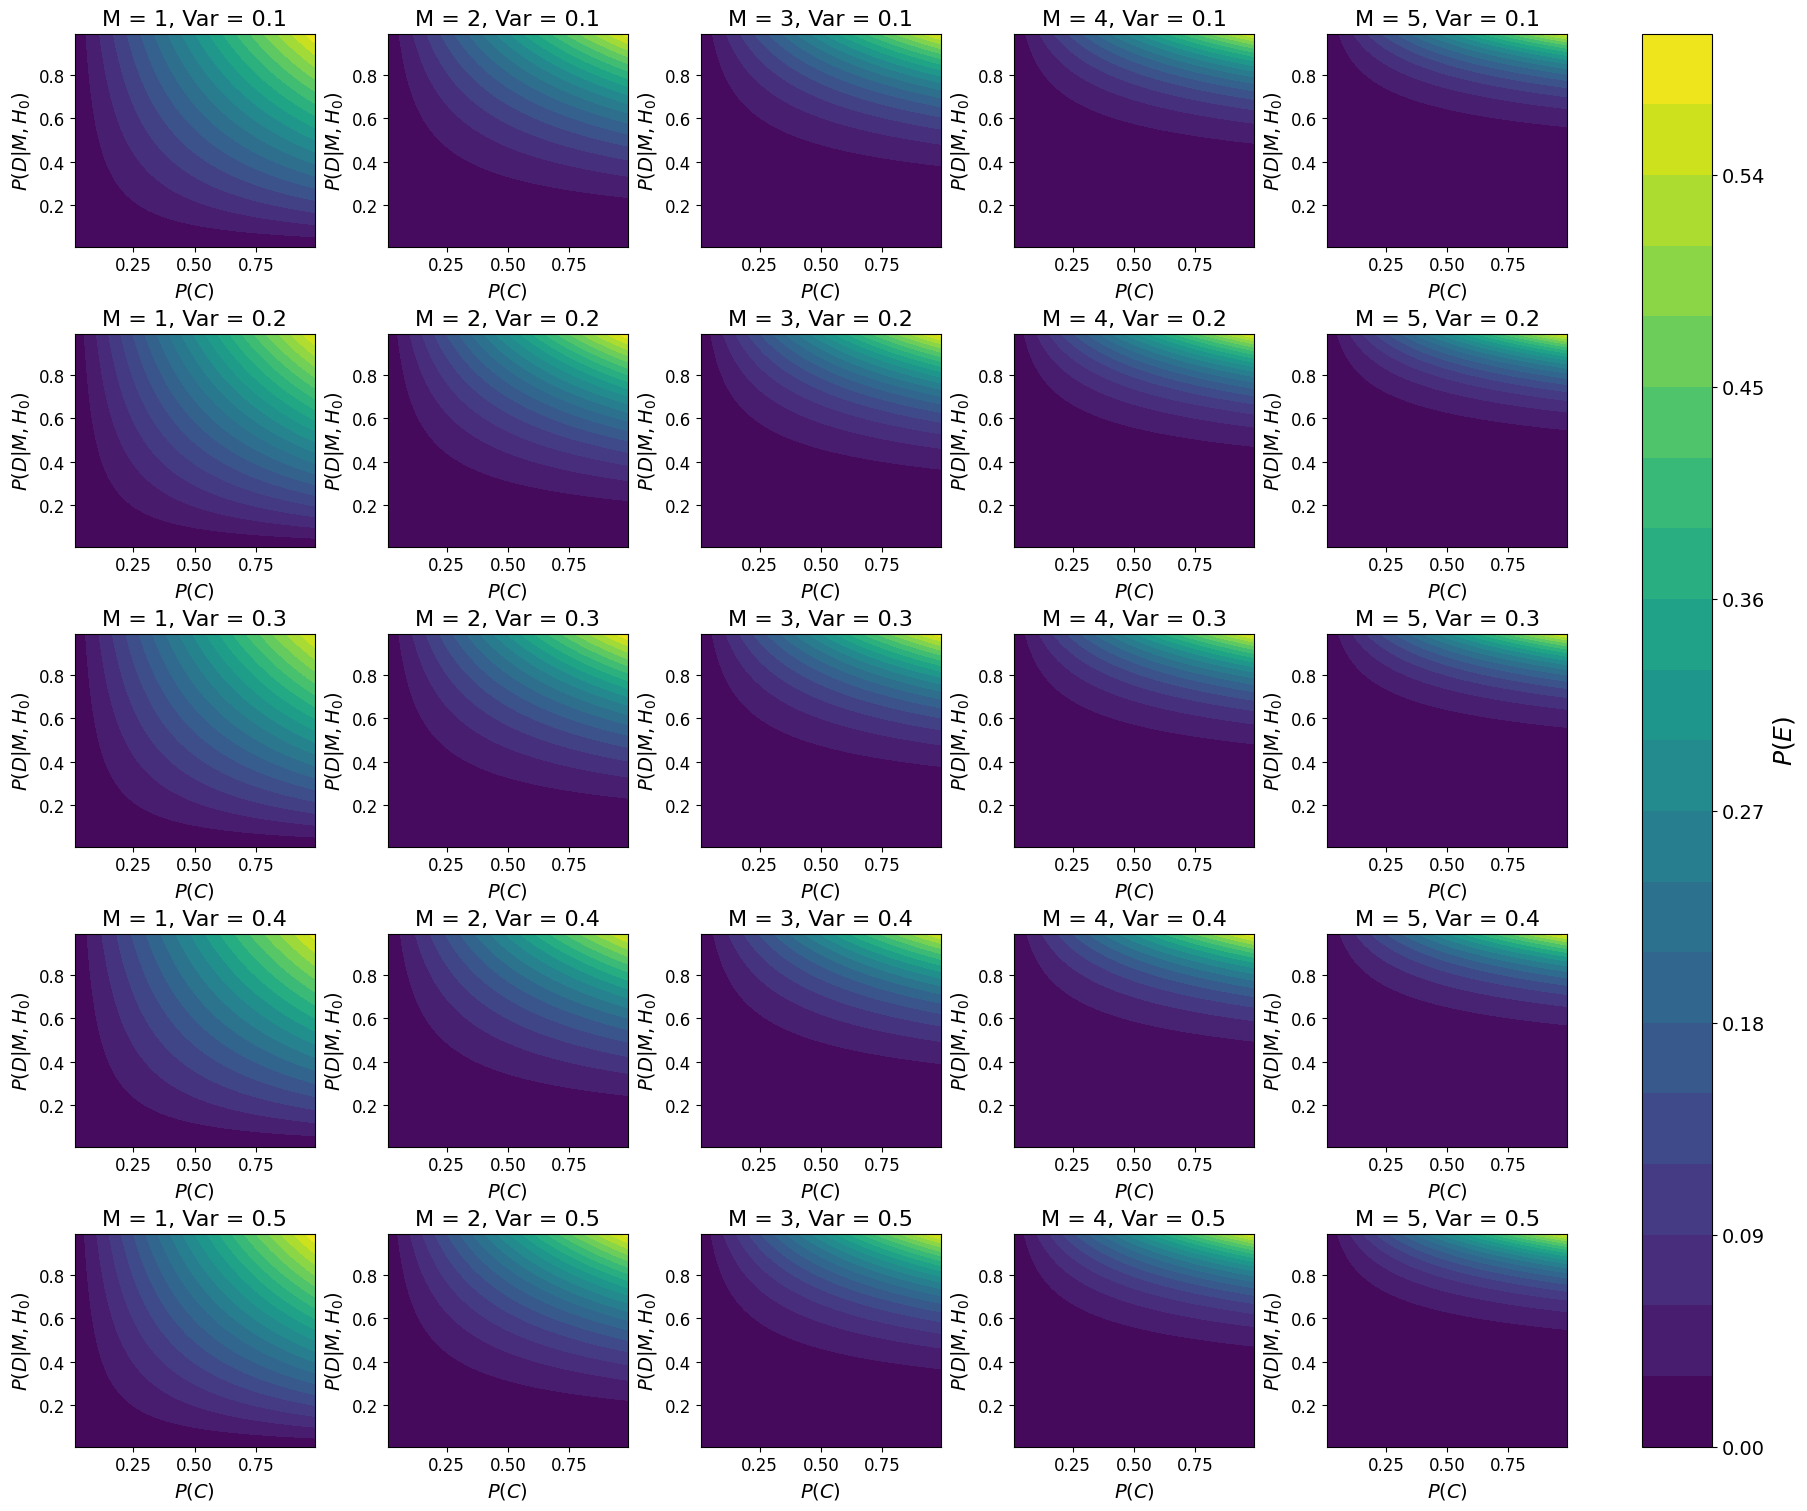

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define probability range for P(C) and P(D | M, Ho)
p_c = np.linspace(0.01, 0.99, 100)  # Probability of concentration
p_d = np.linspace(0.01, 0.99, 100)  # Probability of deviation given concentration

# Create a meshgrid
P_C, P_D = np.meshgrid(p_c, p_d)

# Define M values and variance values to consider
M_values = [1, 2, 3, 4, 5]
Var_values = [.1, .2, .3, .4, .5]

# Create subplots for different combinations of M and variance
fig, axes = plt.subplots(len(Var_values), len(M_values), figsize=(18, 15), constrained_layout=True)

# Loop through M values and variance values to generate contour plots
for i, Var in enumerate(Var_values):
    for j, M in enumerate(M_values):
        P_E = P_C * (P_D ** M) * np.exp(-Var)  # Adjusting P(E) based on M and variance

        contour = axes[i, j].contourf(P_C, P_D, P_E, levels=20, cmap='viridis')
        axes[i, j].set_xlabel(r'$P(C)$', fontsize=14)
        axes[i, j].set_ylabel(r'$P(D | M, H_0)$', fontsize=14)
        axes[i, j].set_title(f'M = {M}, Var = {Var}', fontsize=16)

# Adjust layout and add a single colorbar
cbar = fig.colorbar(contour, ax=axes.ravel().tolist(), orientation='vertical')
cbar.set_label(r'$P(E)$', fontsize=18)
cbar.ax.tick_params(labelsize=14)

# Adjust tick sizes for all axes
for ax in axes.ravel():
    ax.tick_params(axis='both', which='major', labelsize=12)

# Show the figure
plt.show()


# FERP Test

In [71]:
import numpy as np
import pandas as pd
from scipy.stats import hypergeom, t, invgamma, beta, multinomial, norm, chi2

# ---------------------------------- #
# Frequentist FERP (Updated) #
# ---------------------------------- #
def frequentist_ferp(df):
    """
    Implements Frequentist FERP using the hypergeometric distribution for ranking concentration
    and t-distribution for deviation. Returns p-values for each individual.
    """
    N, R = df.shape  # N individuals, R raters
    rank_counts = df.apply(pd.Series.value_counts, axis=1).fillna(0)  # Count occurrences of each rank

    results = []
    for i in range(N):
        counts = rank_counts.iloc[i, :].values
        max_count = int(np.max(counts))  # Ensure max_count is an integer

        # Ensure all hypergeometric inputs are integers
        M = int(R)  # Total number of ranks
        K = int(R // df.shape[1])  # Expected uniform distribution count (integer)
        p_concentration = np.sum([
            hypergeom.sf(int(x - 1), M, K, M) for x in range(max_count, M + 1)
        ])

        # Compute ranking deviation (deviation from median)
        rank_median = np.median(df.iloc[i, :])
        rank_std = np.std(df.iloc[i, :], ddof=1)
        t_statistic = (np.mean(df.iloc[i, :]) - rank_median) / (rank_std / np.sqrt(R))
        p_deviation = 2 * t.sf(np.abs(t_statistic), df=R-1)

        # Joint probability (Bonferroni correction)
        p_joint = min(1, 2 * min(p_concentration, p_deviation))

        results.append([p_concentration, p_deviation, p_joint])

    return pd.DataFrame(results, columns=["p_concentration", "p_deviation", "p_joint"])


# ---------------------------------- #
# Bayesian FERP (Normal - Fixed) #
# ---------------------------------- #
def bayesian_ferp_normal(df, alpha_prior=1, beta_prior=1, gamma=2, delta=2):

    N, R = df.shape
    rank_counts = df.apply(pd.Series.value_counts, axis=1).fillna(0)

    results = []

    for i in range(N):
        counts = rank_counts.iloc[i, :].values
        max_count = np.max(counts)

        # Dirichlet-Multinomial prior
        dirichlet_posterior = np.prod([
            beta(alpha_prior + c, beta_prior + R - c).mean() for c in counts
        ]) ** (1 / R)  # Scale down

        # Compute ranking deviation probability
        rank_median = np.median(df.iloc[i, :])
        rank_std = np.std(df.iloc[i, :], ddof=1)

        # Adjusted variance calculation
        adjusted_variance = invgamma.rvs(gamma + 0.5, scale=delta + ((np.mean(df.iloc[i, :]) - rank_median) / (rank_std + 1e-6))**2 + 1.0)

        # Compute Normal likelihood
        likelihood = norm.pdf(np.mean(df.iloc[i, :]), loc=rank_median, scale=np.sqrt(adjusted_variance + 1.0))

        # Normalize properly
        posterior_prob = dirichlet_posterior * likelihood
        posterior_prob = posterior_prob / (posterior_prob + 0.1)  # Prevent extreme scaling

        results.append(posterior_prob)

    return pd.DataFrame(results, columns=["posterior_prob"])


# ---------------------------------- #
# Bayesian FERP (Student-t, MCMC - Fixed) #
# ---------------------------------- #

def bayesian_ferp_t_fixed(df, num_samples=1000):

    N, R = df.shape

    # Standardize rankings (zero mean, unit variance)
    df_normalized = (df - df.mean(axis=1).values[:, None]) / (df.std(axis=1, ddof=1).values[:, None] + 1e-6)

    rank_counts = df_normalized.apply(pd.Series.value_counts, axis=1).fillna(0)

    results = []

    for i in range(N):
        counts = rank_counts.iloc[i, :].values
        max_count = np.max(counts)

        # Adjusted prior distributions
        alpha_prior, beta_prior = 10*R,10*R # Dirichlet prior
        gamma, delta = .05,.05 # Less restrictive variance prior
        nu_prior = 20  # Adjusted degrees of freedom for stability

        # Compute Dirichlet posterior probability
        dirichlet_posterior = np.prod([
            beta(alpha_prior + c, beta_prior + R - c).mean() for c in counts
        ])

        # Compute ranking deviation probability using MCMC sampling
        rank_median = np.median(df_normalized.iloc[i, :])
        rank_std = np.std(df_normalized.iloc[i, :], ddof=1) + 1e-6  # Avoid division by zero

        # Generate variance samples from the Inverse-Gamma prior
        variance_samples = invgamma.rvs(gamma + 0.5, scale=delta + ((np.mean(df_normalized.iloc[i, :]) - rank_median) / rank_std)**2 + 1.0, size=num_samples)

        # Constrain variance samples to avoid near-zero values
        variance_samples = np.maximum(variance_samples, 1e-3)

        # Compute the Student-t likelihood for each sample (log version for stability)
        log_likelihoods = np.array([
            np.log(t.pdf(np.mean(df_normalized.iloc[i, :]), df=nu_prior, loc=rank_median, scale=np.sqrt(var)))
            for var in variance_samples
        ])

        # Apply log-sum-exp trick for numerical stability
        log_mean_likelihood = np.log(np.mean(np.exp(log_likelihoods)))

        # Compute posterior probability and normalize
        log_posterior_prob = np.log(dirichlet_posterior) + log_mean_likelihood

        # Convert log probabilities back to probability space (avoid direct scaling)
        posterior_prob = np.exp(log_posterior_prob)

        # Normalize using softmax-like scaling
        posterior_prob /= np.sum(posterior_prob) + 1e-6  # Avoid division by zero

        results.append(posterior_prob)
    return pd.DataFrame(results, columns=["posterior_prob"])




def posterior_predictive_check(df, num_samples=1000):

    N, R = df.shape

    # Compute empirical rank distribution
    real_distribution = (df.apply(pd.Series.value_counts, axis=0).fillna(0).sum(axis=1) / (N * R)).values

    # Generate a posterior predictive simulated ranking distribution
    simulated_ranks = np.zeros((num_samples, R))
    for i in range(num_samples):
        simulated_ranks[i, :] = np.random.choice(df.values.flatten(), size=R, replace=True)

    simulated_distribution = (pd.DataFrame(simulated_ranks).apply(pd.Series.value_counts, axis=0).fillna(0).sum(axis=1) / (num_samples * R)).values

    # Compute divergence to assess model fit
    divergence = np.sum((real_distribution - simulated_distribution) ** 2)

    print("\nPosterior Predictive Check Results:")
    print("Real Rank Distribution:", np.round(real_distribution, 3))
    print("Simulated Rank Distribution:", np.round(simulated_distribution, 3))

    # Interpretation
    if divergence < 0.01:
        print("✅ No significant difference between real and simulated rankings. Model is well-calibrated.")
    else:
        print("⚠️ Significant difference detected. Model might be overfitting.")

# ---------------------------------- #
# Global FERP Test #
# ---------------------------------- #
def global_ferp(df):
    """
    Computes the global FERP test for evaluating ranking extremity across all raters.
    Returns overall test results and individual FERP assessments.
    """
    # Compute individual FERP results
    frequentist_results = frequentist_ferp(df)
    bayesian_normal_results = bayesian_ferp_normal(df)
    bayesian_t_results = bayesian_ferp_t_fixed(df)

    # Combine results
    combined_results = pd.concat([frequentist_results, bayesian_normal_results, bayesian_t_results], axis=1)

    # Global chi-squared test
    global_statistic = -2 * np.sum(np.log(combined_results["p_joint"]))  # Using frequentist joint p-values
    df_adjusted = df.shape[0]  # Degrees of freedom adjustment
    global_p_value = chi2.sf(global_statistic, df=df_adjusted)

    return global_p_value, combined_results

# ---------------------------------- #
# Example Usage #
# ---------------------------------- #
np.random.seed(42)
sample_df = pd.DataFrame(np.tile(np.arange(1, 21), (20, 1)))

for i in range(sample_df.shape[0]):
    np.random.shuffle(sample_df.iloc[i, :].values)

#sample_df=pd.read_csv("/content/Book2.csv")

print("Generated Ranking Matrix:\n", sample_df)

# Run Global FERP
global_p, all_ferp_results = global_ferp(sample_df)

print("\nGlobal FERP p-value:", global_p)
print("\nAll Individual FERP Results:\n", all_ferp_results)
temp=posterior_predictive_check(sample_df, num_samples=5000)
print(temp)


Generated Ranking Matrix:
     0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0    1  18  16   2   9   6  12   4  19  17  14   3  10  20   5  13   8  11   
1   20  17  16   6   5  13  15   8   4   7   3  10  14  11  19   9  18  12   
2   11   8   1   3   6  19  17  13   5  15  16  10   2  14  12  20   4  18   
3    1  19   7   9  18  12   5  10  13  11   6  20  16   8   2   4  17  14   
4    6   3  11  20   1  13  10  17   2   5  18   9  12   7  19   8  15  16   
5    4   2   5   6  16  17  10  11  14   3  19  20  12  18   8   9   7   1   
6   14  11  13  17  10   6   4   3   5  16  15  18   1   2  12   8  19  20   
7   18  19   2   6   4  16   8  12  17   9  11  13   7  10  20   1   3  14   
8   18  12   8  14   1  10   5   9   2   6   3  17  20  16   4  19  11  15   
9    5  10   2  16   8   6  17   3  19   4  13  18   9  15   1  14   7  11   
10   3   7  17   5  18   2  14  13  20   4   9  16   6  11  15   8  12  10   
11  15   4  10  19   9  12  18   7   